In [2]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: /home/xiaotong/Projects/311-service-resolution-prediction
Added the following directory to the PYTHONPATH: /home/xiaotong/Projects/311-service-resolution-prediction
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

In [29]:
import datetime
import requests
import pandas as pd
import hopsworks
from mlfs.airquality import util
import datetime
from pathlib import Path
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")


project = hopsworks.login(
    api_key_value="YOUR_API_KEY",  
    host="c.app.hopsworks.ai", 
    project="Lab1_xiaotong",  
    engine="python"  
)

2026-01-10 15:56:55,008 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-10 15:56:55,010 INFO: Initializing external client
2026-01-10 15:56:55,011 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-10 15:56:56,392 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286339


In [30]:
import hopsworks

# project = hopsworks.login()
fs = project.get_feature_store()


fg_311 = fs.get_feature_group(
    name="nyc_311_service_request",
    version=1
)
df_clean = fg_311.read()
df_clean = df_clean.sort_values("created_date").reset_index(drop=True)
display(df_clean.head())
print("Number of rows:", len(df_clean))


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (68.56s) 


,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,borough,is_work_day,is_work_hours
0,2025-09-01 00:00:00+00:00,2025-09-02 12:27:00+00:00,DSNY,Department of Sanitation,Derelict Vehicles,Derelict Vehicles,Street,QUEENS,0,0
1,2025-09-01 00:00:10+00:00,2025-09-01 00:26:39+00:00,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Music,Street/Sidewalk,QUEENS,0,0
2,2025-09-01 00:00:11+00:00,2025-09-01 03:08:50+00:00,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,BRONX,0,0
3,2025-09-01 00:00:13+00:00,2025-09-01 04:22:30+00:00,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,BRONX,0,0
4,2025-09-01 00:00:15+00:00,2025-09-01 16:40:30+00:00,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,QUEENS,0,0


Number of rows: 923649


In [31]:
fg_weather = fs.get_feature_group(
    name="nyc_weather_daily",
    version=1
)
borough_weather_daily = fg_weather.read()
borough_weather_daily

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


,borough,date,temperature_mean,precipitation_sum,wind_speed_mean,latitude,longitude
0,MANHATTAN,2025-11-02,8.987500,0.0,4.858333,40.7829,-73.9654
1,BROOKLYN,2025-11-16,9.754167,4.7,20.287500,40.6928,-73.9903
2,BROOKLYN,2025-09-20,19.645833,0.0,10.508333,40.6928,-73.9903
3,STATEN ISLAND,2025-09-23,22.925000,2.4,8.283333,40.6437,-74.0736
4,QUEENS,2025-12-03,1.275000,0.0,9.179167,40.7769,-73.8740
...,...,...,...,...,...,...,...
650,MANHATTAN,2025-12-24,3.304167,0.0,13.879167,40.7829,-73.9654
651,MANHATTAN,2025-12-21,2.225000,0.0,14.466667,40.7829,-73.9654
652,STATEN ISLAND,2025-12-27,-2.508333,4.8,12.320833,40.6437,-74.0736
653,QUEENS,2025-12-19,9.116667,24.6,22.537500,40.7769,-73.8740


In [32]:
import pandas as pd
TZ = "America/New_York"

weather_small = borough_weather_daily.copy()
weather_small["borough_upper"] = weather_small["borough"].astype(str).str.upper().str.strip()
weather_small["service_date"] = pd.to_datetime(weather_small["date"], errors="coerce").dt.date
weather_small = weather_small[[
    "borough_upper",
    "service_date",
    "temperature_mean",
    "precipitation_sum",
    "wind_speed_mean",
]].rename(
    columns={
        "temperature_mean": "weather_temperature_mean",
        "precipitation_sum": "weather_precipitation_sum",
        "wind_speed_mean": "weather_wind_speed_mean",
    }
)

df_final = df_clean.copy()
df_final["borough_upper"] = df_final["borough"].astype(str).str.upper().str.strip()

_created_naive = pd.to_datetime(df_final["created_date"], errors="coerce")
_service_date_local = _created_naive.dt.date

_created_utc = pd.to_datetime(df_final["created_date"], errors="coerce", utc=True)
_service_date_utc_to_ny = _created_utc.dt.tz_convert(TZ).dt.date

_sample_n = 100_000
_sample = df_final[["borough_upper"]].copy()
_sample["d_local"] = _service_date_local
_sample["d_utc_to_ny"] = _service_date_utc_to_ny
_sample = _sample.dropna(subset=["borough_upper"])
if len(_sample) > _sample_n:
    _sample = _sample.sample(_sample_n, random_state=42)

_tmp_local = _sample.merge(
    weather_small[["borough_upper", "service_date"]],
    left_on=["borough_upper", "d_local"],
    right_on=["borough_upper", "service_date"],
    how="left",
)
_tmp_utc = _sample.merge(
    weather_small[["borough_upper", "service_date"]],
    left_on=["borough_upper", "d_utc_to_ny"],
    right_on=["borough_upper", "service_date"],
    how="left",
)

rate_local = _tmp_local["service_date"].notna().mean() if len(_tmp_local) else 0.0
rate_utc = _tmp_utc["service_date"].notna().mean() if len(_tmp_utc) else 0.0

use_utc_to_ny = rate_utc > rate_local
print(f"Join match rate (sample): local={rate_local:.3f}, utc_to_ny={rate_utc:.3f} -> using {'utc_to_ny' if use_utc_to_ny else 'local'}")

df_final["service_date"] = _service_date_utc_to_ny if use_utc_to_ny else _service_date_local

df_final = df_final.merge(weather_small, on=["borough_upper", "service_date"], how="left")

_df_weather_cols = ["weather_temperature_mean", "weather_precipitation_sum", "weather_wind_speed_mean"]
print("Weather non-null rate:", df_final[_df_weather_cols].notna().mean().to_dict())

df_final = df_final.drop(columns=["borough_upper", "service_date"])

df_final[_df_weather_cols].head()

Join match rate (sample): local=1.000, utc_to_ny=0.998 -> using local
Weather non-null rate: {'weather_temperature_mean': 0.9996199855139777, 'weather_precipitation_sum': 0.9996199855139777, 'weather_wind_speed_mean': 0.9996199855139777}


,weather_temperature_mean,weather_precipitation_sum,weather_wind_speed_mean
0,21.379167,0.0,8.300000
1,21.379167,0.0,8.300000
2,21.204167,0.0,8.066667
3,21.204167,0.0,8.066667
4,21.379167,0.0,8.300000


In [33]:

OUTPUT_CSV = "nyc_weather.csv"

borough_weather_daily.to_csv(
    OUTPUT_CSV,
    index=False,
    encoding="utf-8-sig",  
)

In [34]:
import pandas as pd


TZ = "America/New_York"
weather_small = borough_weather_daily.copy()
weather_small["borough_upper"] = weather_small["borough"].astype(str).str.upper().str.strip()
weather_small["service_date"] = pd.to_datetime(weather_small["date"], errors="coerce").dt.date
weather_small = weather_small[[
    "borough_upper",
    "service_date",
    "temperature_mean",
    "precipitation_sum",
    "wind_speed_mean",
]].rename(
    columns={
        "temperature_mean": "weather_temperature_mean",
        "precipitation_sum": "weather_precipitation_sum",
        "wind_speed_mean": "weather_wind_speed_mean",
    }
)

df_final = df_clean.copy()
df_final["borough_upper"] = df_final["borough"].astype(str).str.upper().str.strip()


_created_naive = pd.to_datetime(df_final["created_date"], errors="coerce")
_service_date_local = _created_naive.dt.date

_created_utc = pd.to_datetime(df_final["created_date"], errors="coerce", utc=True)
_service_date_utc_to_ny = _created_utc.dt.tz_convert(TZ).dt.date

_sample_n = 100_000
_sample = df_final[["borough_upper"]].copy()
_sample["d_local"] = _service_date_local
_sample["d_utc_to_ny"] = _service_date_utc_to_ny
_sample = _sample.dropna(subset=["borough_upper"])
if len(_sample) > _sample_n:
    _sample = _sample.sample(_sample_n, random_state=42)

_tmp_local = _sample.merge(
    weather_small[["borough_upper", "service_date"]],
    left_on=["borough_upper", "d_local"],
    right_on=["borough_upper", "service_date"],
    how="left",
)
_tmp_utc = _sample.merge(
    weather_small[["borough_upper", "service_date"]],
    left_on=["borough_upper", "d_utc_to_ny"],
    right_on=["borough_upper", "service_date"],
    how="left",
)

rate_local = _tmp_local["service_date"].notna().mean() if len(_tmp_local) else 0.0
rate_utc = _tmp_utc["service_date"].notna().mean() if len(_tmp_utc) else 0.0

use_utc_to_ny = rate_utc > rate_local
print(f"Join match rate (sample): local={rate_local:.3f}, utc_to_ny={rate_utc:.3f} -> using {'utc_to_ny' if use_utc_to_ny else 'local'}")

df_final["service_date"] = _service_date_utc_to_ny if use_utc_to_ny else _service_date_local

df_final = df_final.merge(weather_small, on=["borough_upper", "service_date"], how="left")

_df_weather_cols = ["weather_temperature_mean", "weather_precipitation_sum", "weather_wind_speed_mean"]
print("Weather non-null rate:", df_final[_df_weather_cols].notna().mean().to_dict())

df_final = df_final.drop(columns=["borough_upper", "service_date"])

df_final.head(200)


Join match rate (sample): local=1.000, utc_to_ny=0.998 -> using local
Weather non-null rate: {'weather_temperature_mean': 0.9996199855139777, 'weather_precipitation_sum': 0.9996199855139777, 'weather_wind_speed_mean': 0.9996199855139777}


,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,borough,is_work_day,is_work_hours,weather_temperature_mean,weather_precipitation_sum,weather_wind_speed_mean
0,2025-09-01 00:00:00+00:00,2025-09-02 12:27:00+00:00,DSNY,Department of Sanitation,Derelict Vehicles,Derelict Vehicles,Street,QUEENS,0,0,21.379167,0.0,8.300000
1,2025-09-01 00:00:10+00:00,2025-09-01 00:26:39+00:00,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Music,Street/Sidewalk,QUEENS,0,0,21.379167,0.0,8.300000
2,2025-09-01 00:00:11+00:00,2025-09-01 03:08:50+00:00,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,BRONX,0,0,21.204167,0.0,8.066667
3,2025-09-01 00:00:13+00:00,2025-09-01 04:22:30+00:00,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,BRONX,0,0,21.204167,0.0,8.066667
4,2025-09-01 00:00:15+00:00,2025-09-01 16:40:30+00:00,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,QUEENS,0,0,21.379167,0.0,8.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2025-09-01 00:18:55+00:00,2025-09-01 01:14:52+00:00,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,BRONX,0,0,21.204167,0.0,8.066667
196,2025-09-01 00:18:56+00:00,2025-09-01 01:49:27+00:00,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,MANHATTAN,0,0,21.479167,0.0,8.325000
197,2025-09-01 00:19:25+00:00,2025-09-01 00:28:41+00:00,NYPD,New York City Police Department,Traffic,Drag Racing,Street/Sidewalk,QUEENS,0,0,21.379167,0.0,8.300000
198,2025-09-01 00:19:28+00:00,2025-09-01 01:04:01+00:00,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,BROOKLYN,0,0,21.816667,0.0,8.625000


In [35]:
df_final.to_csv("df_final.csv", index=False, encoding="utf-8-sig")

In [36]:
import pandas as pd

df = df_final.copy()

df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
df["closed_date"]  = pd.to_datetime(df["closed_date"], errors="coerce")
df = df.dropna(subset=["created_date", "closed_date"]).copy()

df["resolution_hours"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 3600

df = df[df["resolution_hours"] >= 0].copy()
df["label_48h"] = (df["resolution_hours"] <= 48).astype(int)

df[["resolution_hours","label_48h"]].head()
df["created_hour"] = df["created_date"].dt.hour
df["created_weekday"] = df["created_date"].dt.weekday
df["created_month"] = df["created_date"].dt.month
df["is_weekend"] = (df["created_weekday"] >= 5).astype(int)


## Training a classification model 
It will make the model training easier if there is no missing data in the rows, so we drop any rows with missing data.

In [37]:
target = "label_48h"

categorical_features = [
    "agency", "agency_name", "complaint_type", "descriptor",
    "location_type", "borough"
]

numeric_features = [
    "is_work_day", "is_work_hours",
    "created_hour", "created_weekday", "created_month", "is_weekend",
    "weather_temperature_mean", "weather_precipitation_sum", "weather_wind_speed_mean"
]

categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

X = df[categorical_features + numeric_features].copy()
y = df[target].copy()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )
train_start = pd.Timestamp("2025-09-01", tz="UTC")
train_end   = pd.Timestamp("2025-12-01", tz="UTC")
train_mask = (df["created_date"] >= train_start) & (df["created_date"] < train_end)
test_mask  = df["created_date"] >= train_end

df_train = df.loc[train_mask]
df_test  = df.loc[test_mask]
X_train = df_train[categorical_features + numeric_features]
y_train = df_train[target]

X_test = df_test[categorical_features + numeric_features]
y_test = df_test[target]
print(len(X_train))
print(len(X_test))

753048
170532


In [39]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), numeric_features),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_features),
    ],
    remainder="drop"
)

clf = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"   
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", clf)
])

model.fit(X_train, y_train)

pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, proba))


              precision    recall  f1-score   support

           0     0.6789    0.3947    0.4991     32360
           1     0.8709    0.9563    0.9116    138172

    accuracy                         0.8497    170532
   macro avg     0.7749    0.6755    0.7054    170532
weighted avg     0.8345    0.8497    0.8333    170532

ROC-AUC: 0.9221809669551793


## Upload trained model to Hopsworks Model Registry

In [27]:
import os
import json
import joblib
import hopsworks
from sklearn.metrics import f1_score, roc_auc_score

auc = roc_auc_score(y_test, proba)
f1 = f1_score(y_test, pred)

res_dict = {
    "roc_auc": float(auc),
    "f1": float(f1),
}

model_dir = "nyc_311_within48h_model"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(model, os.path.join(model_dir, "model.pkl"))

metadata = {
    "target": "label_48h",
    "categorical_features": list(categorical_features),
    "numeric_features": list(numeric_features),
    "threshold": 0.5,
}
with open(os.path.join(model_dir, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

project = hopsworks.login(
    api_key_value="YOUR_API_KEY", 
    host="c.app.hopsworks.ai",  
    project="Lab1_xiaotong",  
    engine="python"  
)

mr = project.get_model_registry()

hs_model = mr.python.create_model(
    name="nyc_311_within48h_xgb",   
    metrics=res_dict,               
    description="311 within-48h classifier: sklearn Pipeline (imputer+onehot) + XGBClassifier",
    # feature_view=feature_view,     
)

hs_model.save(model_dir)             
print("Uploaded model:", hs_model.name, "version:", hs_model.version)


2026-01-09 23:31:09,050 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-09 23:31:09,065 INFO: Initializing external client
2026-01-09 23:31:09,065 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-09 23:31:10,376 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286339


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/xiaotong/Projects/311-service-resolution-prediction/notebooks/airquality/nyc_311_within48h_mod…

Uploading /home/xiaotong/Projects/311-service-resolution-prediction/notebooks/airquality/nyc_311_within48h_mod…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286339/models/nyc_311_within48h_xgb/1
Uploaded model: nyc_311_within48h_xgb version: 1


## Training a model to predict resolution hours

In [40]:
target = "resolution_hours"

categorical_features = [
    "agency", "agency_name", "complaint_type", "descriptor",
    "location_type", "borough"
]

numeric_features = [
    "is_work_day", "is_work_hours",
    "created_hour", "created_weekday", "created_month", "is_weekend",
    "weather_temperature_mean", "weather_precipitation_sum", "weather_wind_speed_mean"
]

categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

X = df[categorical_features + numeric_features].copy()
y = df[target].copy()

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )
train_start = pd.Timestamp("2025-09-01", tz="UTC")
train_end   = pd.Timestamp("2025-12-01", tz="UTC")
train_mask = (df["created_date"] >= train_start) & (df["created_date"] < train_end)
test_mask  = df["created_date"] >= train_end

df_train = df.loc[train_mask]
df_test  = df.loc[test_mask]
X_train = df_train[categorical_features + numeric_features]
y_train = df_train[target]

X_test = df_test[categorical_features + numeric_features]
y_test = df_test[target]
print(len(X_train))
print(len(X_test))

753048
170532


In [42]:
print(y_train)

0         36.450000
1          0.441389
2          3.144167
3          4.371389
4         16.670833
            ...    
753112    16.487778
753113     8.263056
753114     8.862500
753115    15.827222
753116     8.248889
Name: resolution_hours, Length: 753048, dtype: float64


In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), numeric_features),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_features),
    ],
    remainder="drop"
)

reg = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
    tree_method="hist"
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", reg)
])


MAE  (hours): 18.49
RMSE (hours): 43.83
R²          : 0.1740


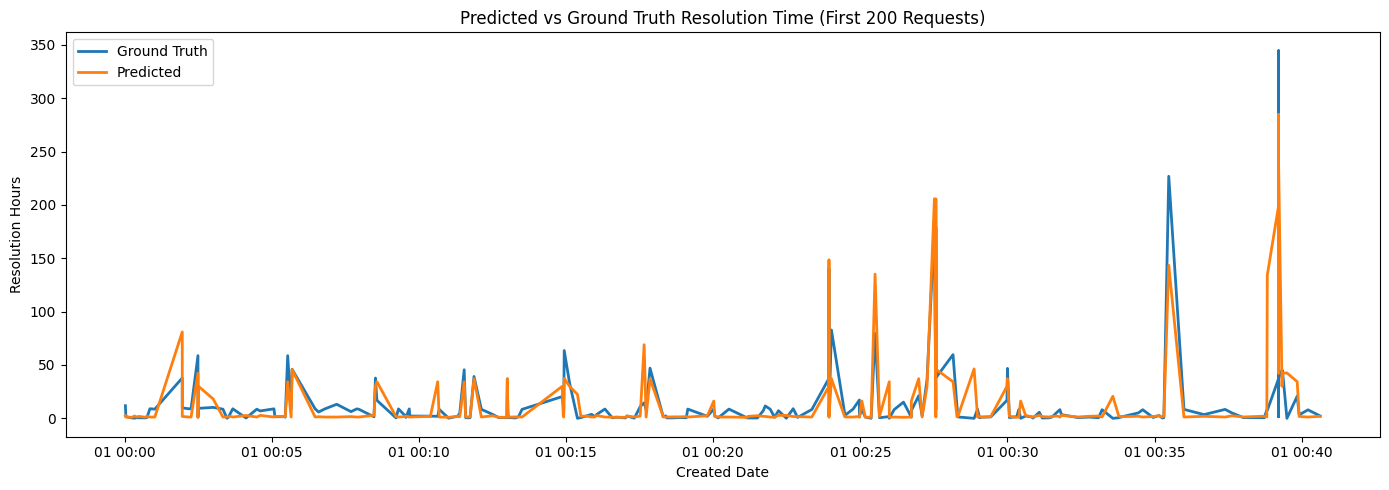

In [44]:
# y_train / y_test = resolution_hours
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE  (hours): {mae:.2f}")
print(f"RMSE (hours): {rmse:.2f}")
print(f"R²          : {r2:.4f}")
import matplotlib.pyplot as plt

df_plot = X_test.copy()
df_plot["y_true"] = y_test.values
df_plot["y_pred"] = y_pred

df_plot["created_date"] = df_test.loc[X_test.index, "created_date"]

df_plot = df_plot.sort_values("created_date")

N = 200
df_plot = df_plot.head(N)

plt.figure(figsize=(14, 5))
plt.plot(df_plot["created_date"], df_plot["y_true"], label="Ground Truth", linewidth=2)
plt.plot(df_plot["created_date"], df_plot["y_pred"], label="Predicted", linewidth=2)

plt.xlabel("Created Date")
plt.ylabel("Resolution Hours")
plt.title("Predicted vs Ground Truth Resolution Time (First 200 Requests)")
plt.legend()
plt.tight_layout()
plt.show()


## Upload trained model to Hopsworks Model Registry

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# y_test: ground truth resolution_hours
# y_pred: model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

res_dict = {
    "mae_hours": float(mae),
    "rmse_hours": float(rmse),
    "r2": float(r2),
}


import os
import json
import joblib

model_dir = "nyc_311_resolution_hours_xgb"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(model, os.path.join(model_dir, "model.pkl"))


metadata = {
    "task": "regression",
    "target": "resolution_hours",
    "categorical_features": list(categorical_features),
    "numeric_features": list(numeric_features),
    "model_type": "XGBRegressor",
    "description": "Predict resolution time (hours) for NYC 311 service requests",
}
with open(os.path.join(model_dir, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

    
import hopsworks

project = hopsworks.login(
    api_key_value="YOUR_API_KEY", 
    host="c.app.hopsworks.ai",  
    project="Lab1_xiaotong",  
    engine="python"  
)

mr = project.get_model_registry()
hs_model = mr.python.create_model(
    name="nyc_311_resolution_hours_xgb",   
    metrics=res_dict,
    description=(
        "NYC 311 resolution time regressor: "
        "sklearn Pipeline (imputer + one-hot) + XGBRegressor. "
        "Predicts resolution time in hours."
    ),
    # feature_view=feature_view, 
)

hs_model.save(model_dir)

print(
    "Uploaded model:",
    hs_model.name,
    "version:",
    hs_model.version
)


2026-01-10 16:32:45,112 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-10 16:32:45,120 INFO: Initializing external client
2026-01-10 16:32:45,121 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-10 16:32:46,438 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286339


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/xiaotong/Projects/311-service-resolution-prediction/notebooks/airquality/nyc_311_resolution_ho…

Uploading /home/xiaotong/Projects/311-service-resolution-prediction/notebooks/airquality/nyc_311_resolution_ho…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286339/models/nyc_311_resolution_hours_xgb/1
Uploaded model: nyc_311_resolution_hours_xgb version: 1
